<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [5]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

## 1) *Optional:* Scrape 100 Job Listings that contain the title "Data Scientist" from indeed.com

At a minimum your final dataframe of job listings should contain
- Job Title
- Job Description

If you choose to not to scrape the data, there is a CSV with outdated data in the directory. Remeber, if you scrape Indeed, you're helping yourself find a job. ;)

In [ ]:
# # recommended scrappers:
# from bs4 import BeautifulSoup
# import requests

## 2) Use Spacy to tokenize / clean the listings 

In [6]:
nlp = spacy.load("en_core_web_lg")

In [7]:
df = pd.read_csv('data/job_listings.csv')
df.head()

,Unnamed: 0,description,title
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


In [8]:
# trying to get rid of html tags

df['description'] = df['description'].str.replace('<[^<]+?>', '')

In [9]:
df.head()

,Unnamed: 0,description,title
0,0,"b""Job Requirements:\nConceptual understanding ...",Data scientist
1,1,"b'Job Description\n\nAs a Data Scientist 1, yo...",Data Scientist I
2,2,b'As a Data Scientist you will be working on c...,Data Scientist - Entry Level
3,3,"b'$4,969 - $6,756 a monthContractUnder the gen...",Data Scientist
4,4,b'Location: USA \xe2\x80\x93 multiple location...,Data Scientist


In [12]:
import re
# re.sub(r'[^a-zA-Z ^0-9]', '', _____)
# df['pricing'] = re.sub(r"[^0-9]+", "", df['pricing'])

# df['description'] = re.sub(r'[^a-zA-Z ^0-9]', '', df['description'])

for row in df['description']:
    re.sub(r'[^a-zA-Z ^0-9]', '', row)

In [13]:
df.head()

,Unnamed: 0,description,title
0,0,"b""Job Requirements:\nConceptual understanding ...",Data scientist
1,1,"b'Job Description\n\nAs a Data Scientist 1, yo...",Data Scientist I
2,2,b'As a Data Scientist you will be working on c...,Data Scientist - Entry Level
3,3,"b'$4,969 - $6,756 a monthContractUnder the gen...",Data Scientist
4,4,b'Location: USA \xe2\x80\x93 multiple location...,Data Scientist


In [14]:
# look at distribution of document length

doc_len = [len(row) for row in df['description']]

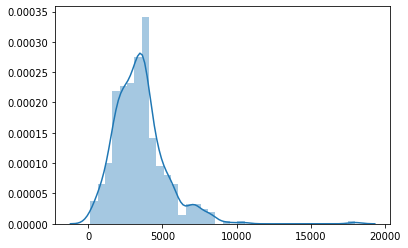

In [16]:
import seaborn as sns

sns.distplot(doc_len);

## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [1]:
# from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# # instatiate transformer
# vect = CountVectorizer()

In [11]:
# Apply CountVectorizer to our Data
# Use custom Spacy Vectorizer


vect = CountVectorizer(stop_words='english', min_df = 0.05, max_df= 0.90, lowercase = True)
vect.fit(df['description'])

sparse_dtm = vect.transform(df['description'])

dtm = pd.DataFrame(sparse_dtm.todense(), columns=vect.get_feature_names()) 

In [12]:
dtm.head()

,000,10,100,2019,40,abilities,ability,able,academic,access,...,x99,x99ll,x99re,x99s,x99t,x9d,xe2,year,years,york
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,2,0,2,2,0,0,8,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


## 4) Visualize the most common word counts

In [24]:
def tokenize(text):
    """Parses a string into a list of semantic units (words)

    Args:
        text (str): The string that the function will tokenize.

    Returns:
        list: tokens parsed out by the mechanics of your choice
    """
    
    tokens = re.sub(r'[^a-zA-Z ^0-9]', '', text)
    tokens = tokens.lower().split()
    
    return tokens

In [ ]:
# # How can we count the raw text?
df['description'].value_counts(normalize=True)[:50]

In [26]:
df['tokens'] = df['description'].apply(tokenize)

In [27]:
# So much magic...

# Object from Base Python
from collections import Counter

# The object `Counter` takes an iterable, but you can instaniate an empty one and update it. 
word_counts = Counter()

# Update it based on a split of each of our documents
df['tokens'].apply(lambda x: word_counts.update(x))

# Print out the 10 most common words
word_counts.most_common(10)

[('and', 11541),
 ('to', 6803),
 ('the', 5229),
 ('of', 4553),
 ('data', 4021),
 ('in', 3526),
 ('a', 3453),
 ('with', 3053),
 ('for', 2028),
 ('or', 1749)]

In [18]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [19]:
# Use the Function
wc = count(df['tokens'])

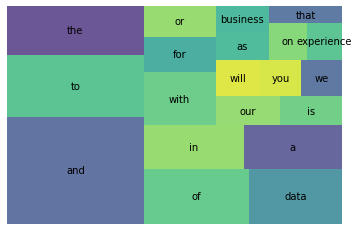

In [29]:
import squarify
import matplotlib.pyplot as plt

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [21]:
from spacy.tokenizer import Tokenizer

# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [30]:
# IF I want to include more, I need to make a union with this new list of stop words

STOP_WORDS = nlp.Defaults.stop_words.union(['i\'ll', 'it.', '..', 'don\'t', '-', 'it\'s', 'i\'ve', 'i\'m', 's', ' '])

In [31]:
# Rerunning the tokenizer function with more stop words...

tokens = []

for doc in tokenizer.pipe(df['description'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())
   
    tokens.append(doc_tokens)
    
df['tokens'] = tokens

In [32]:
df.head()

# Doesn't look right...

,Unnamed: 0,description,title,tokens
0,0,"b""Job Requirements:\nConceptual understanding ...",Data scientist,"[b""job, requirements:\nconceptual, understandi..."
1,1,"b'Job Description\n\nAs a Data Scientist 1, yo...",Data Scientist I,"[b'job, description\n\nas, data, scientist, 1,..."
2,2,b'As a Data Scientist you will be working on c...,Data Scientist - Entry Level,"[b'as, data, scientist, working, consulting, b..."
3,3,"b'$4,969 - $6,756 a monthContractUnder the gen...",Data Scientist,"[b'$4,969, $6,756, monthcontractunder, general..."
4,4,b'Location: USA \xe2\x80\x93 multiple location...,Data Scientist,"[b'location:, usa, \xe2\x80\x93, multiple, loc..."


In [33]:
wc = count(df['tokens'])
wc.head(10)

# okay, that looks alright.

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
56,data,419,3751,1.0,0.029797,0.029797,0.983568
121,business,303,1008,2.0,0.008007,0.037804,0.711268
44,experience,357,941,3.0,0.007475,0.045279,0.838028
70,work,326,876,4.0,0.006959,0.052238,0.765258
210,team,314,726,5.0,0.005767,0.058005,0.737089
60,machine,269,660,6.0,0.005243,0.063248,0.631455
65,learning,265,640,7.0,0.005084,0.068332,0.622066
1,science,229,564,8.0,0.004480,0.072812,0.537559
359,statistical,256,531,9.0,0.004218,0.077030,0.600939
81,new,242,517,10.0,0.004107,0.081137,0.568075


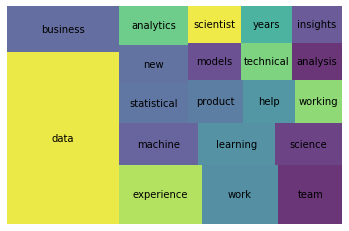

In [34]:
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [36]:
def tokenize(document):
    
    doc = nlp(document)
    
    return [token.lemma_ for token in doc if (token.is_stop != True) 
            and (token.is_punct != True)]

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate vectorizer object
# ngram_range 
# since classification I would tune the ngram_range
tfidf = TfidfVectorizer(tokenizer=tokenize, min_df=0.025, max_df=.95, ngram_range=(1,2))

# Create a vocabulary and get word counts per document
# Learn vocab and transform data into form we want
sparse = tfidf.fit_transform(df['description'])

# Print word counts

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(sparse.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm.head()

,$,+,+ year,1,10,100,12,2,2 year,2019,...,year work,years\xe2\x80\x99,years\xe2\x80\x99 experience,york,york city,you\'ll,you\xe2\x80\x99ll,you\xe2\x80\x99ll work,you\xe2\x80\x99re,you\xe2\x80\x99ve
0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.119624,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.034911,0.038121,0.131641,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.234286,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.168458,0.183943,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words = 'english')

# Create a vocabulary and get word counts per document
# sparse = tfidf.fit_transform(data)
sparse = tfidf.fit_transform(df['description'])

# Print word counts

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(sparse.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm.head()

,00,000,02115,03,0356,04,062,06366,08,10,...,zenreach,zero,zeus,zf,zheng,zillow,zones,zoom,zuckerberg,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.104421,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [39]:
dtm.head()

#looks bad...

,$,+,+ year,1,10,100,12,2,2 year,2019,...,year work,years\xe2\x80\x99,years\xe2\x80\x99 experience,york,york city,you\'ll,you\xe2\x80\x99ll,you\xe2\x80\x99ll work,you\xe2\x80\x99re,you\xe2\x80\x99ve
0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.119624,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.034911,0.038121,0.131641,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.234286,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.168458,0.183943,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
# Instantiate
from sklearn.neighbors import NearestNeighbors


# Fit on TF-IDF Vectors
nn  = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [ ]:
# Query Using kneighbors 
nn.kneighbors([dtm.iloc[0]])

In [45]:
wee_tech = ["""
Our Software Engineers are highly focused on delivering world-class user experiences. Our applications increase efficiency and provide an intuitive approach to completing a myriad of tasks related to a cannabis retailer or cultivator.

As a Data Scientist, you will work closely with our product team to parse and analyze data from the Flowhub platform. Your input will be essential for marketing initiatives and research & development.

Qualifications:
3+ years relevant experience

Excellent problem-solving skills

Eager to make an impact

Be able to see the wood from the trees with regards to issues

Perks:
Competitive salary + stock
Full health benefits (medical, vision, dental)
Flexible time off policy
All the tools you need to be successful at your job
Startup environment with modern and central office space
Free coffee and kombucha on tap
Opportunities to learn, grow, and advance your career
"""]

In [46]:
# Query for Sim of Random doc to BBC
new = tfidf.transform(wee_tech)

nn.kneighbors(new.todense())

(array([[1.25532262, 1.26585951, 1.28125959, 1.281713  , 1.28239812]]),
 array([[309, 331,  61, 287, 136]], dtype=int64))

In [48]:
# Inspect Most relevant result
df['description'][309]

'b\'ContractJob Description\\nWhat You\\xe2\\x80\\x99ll Get to Do:\\nWe are looking for talented IT/Engineer professionals that are excited about the dynamic intelligence community space and using the latest technologies available to create truly rich user experiences. This is your opportunity to work with a highly talented engineering team that builds technology that bridges software and intelligence community needs. Our client engagement processes, the way we collaborate, operate, and deliver value provides an unparalleled opportunity to grow and advance. Choose us, and make delivering innovative work part of your extraordinary career.\\n\\nSummary: BIT Systems Inc., a CACI Company, is looking for Data Scientist/Researchers to work in our research and development lab in the Aurora, CO area. Become a member of a software development team supporting a large, multi-delivery, multi-year development contract supporting national and tactical requirements. Responsible for design analysis, p

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 